Softmax regression is a generalized logistic model, it is also a shallow one-layer neural network. Traditional training methods for classification tasks usually aim to minimize the cross entropy of classes. This is actually equivalent to maximum likelihood estimation of multinomial observations, we could also implement softmax via a Bayesian perspective.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from edward.models import Normal, Categorical

Read MNIST dataset (images of digits from 0-9)

Extracting Datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting Datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting Datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting Datasets/MNIST_data/t10k-labels-idx1-ubyte.gz
Number of training samples: 55000
Number of validation samples: 5000
Number of test samples: 10000


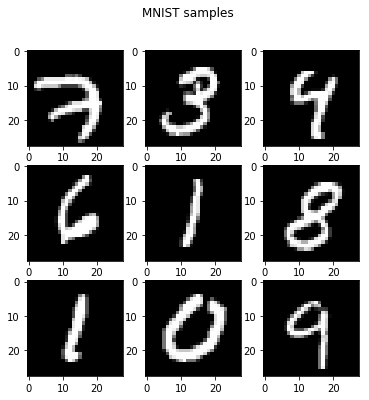

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('Datasets/MNIST_data', one_hot=False)
num_train_samples = mnist.train.num_examples
num_valid_samples = mnist.validation.num_examples
num_test_samples = mnist.test.num_examples

print("Number of training samples: %d" % num_train_samples)
print("Number of validation samples: %d" % num_valid_samples)
print("Number of test samples: %d" % num_test_samples)

# Each image has 28 * 28 = 784 pixels
samples = mnist.train.images[:9]
plt.figure(figsize=(6, 6))
plt.suptitle("MNIST samples")
for i, image in enumerate(samples):
    plt.subplot(3, 3, i+1)
    plt.imshow(image.reshape(28, 28), cmap="gray")
plt.show()

#### 1. Define the model

In [3]:
def softmax(X, W_0, b_0):
    logits = tf.matmul(X, W_0) + b_0
    return logits

#### 2. Priors

In [4]:
num_features = 784
num_classes = 10

W_0 = Normal(loc=tf.zeros([num_features, num_classes]), scale=tf.ones([num_features, num_classes]))
b_0 = Normal(loc=tf.zeros(num_classes), scale=tf.ones(num_classes))

#### 3. For a classification problem, we define $y$ as categorical (multinomial with total count=1) distribution (Note that the multinomial class from tensorflow.contrib.distributions currently does not work, [I reported this issue to Edward](https://github.com/blei-lab/edward/issues/724#issuecomment-321841508)) 

In [5]:
#Use tf.placeholder for batch training
X = tf.placeholder(tf.float32, [None, num_features])
y = Categorical(logits=softmax(X, W_0, b_0))

#### 4. Posteriors

In [6]:
qw_0_loc = tf.Variable(tf.random_normal([num_features, num_classes]))
qw_0_scale = tf.nn.softplus(tf.Variable(tf.random_normal([num_features, num_classes])))
qb_0_loc = tf.Variable(tf.random_normal([num_classes]) + 5)
qb_0_scale = tf.nn.softplus(tf.Variable(tf.random_normal([num_classes])))

qw_0 = Normal(loc=qw_0_loc, scale=qw_0_scale)
qb_0 = Normal(loc=qb_0_loc, scale=qb_0_scale)

#### 5. Training

In [7]:
y_ph = tf.placeholder(tf.int32, [None])
inference = ed.KLqp({W_0: qw_0, b_0: qb_0},  data={y: y_ph})
inference.initialize(n_print=100, n_iter=5000, scale={y: mnist.train.num_examples / 64})

# ed.get_session builds an interactive session in TensorFlow
sess = ed.get_session()
tf.global_variables_initializer().run()
for t in range(inference.n_iter):
    xs, ys = mnist.train.next_batch(64)
    info_dict = inference.update({X: xs, y_ph: ys})
    inference.print_progress(info_dict)

5000/5000 [100%] ██████████████████████████████ Elapsed: 6s | Loss: 32322.275


#### 6. Evaluation on one posterior mode

In [8]:
x_test = mnist.test.images
y_test = mnist.test.labels
logits = softmax(x_test, qw_0, qb_0)
correct_predictions = tf.equal(tf.argmax(logits, 1), y_test)
accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
print("Accuracy on test samples: %.2f%%" % (accuracy.eval()*100))

Accuracy on test samples: 91.32%
